## Code used for processing the energy consumption data from the experiments with parallel mini-batching in MOA


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
PATH_TO_RESULTS = '../results'

In [3]:
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

***

# MOA logs

In [4]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [5]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)
    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate']] 

## Energy Data

In [6]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [7]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
#                 print(spline)
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
#                 if method not in d[algorithm]:
#                     d[algorithm][method] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [8]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
#                             for k6, v6 in v5.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [9]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

# Parse SSH logs

In [10]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
#                     print(line)
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate = spline[1:]
                    else:
                        dataset, alg, rate = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

# Showing and preparing for charts

In [11]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [12]:
def rename_columns_by_rate(df):
#     display(df)
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                              "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                              "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})


In [13]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.15
    alg_order = ['Sequential', 'B1', 'B50', 'B250', 'B500']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 5
    for i in range(versions):
        adf = df.iloc[[i]]
        values_j = [adf.JPI_10.iloc[0], adf.JPI_50.iloc[0], adf.JPI_90.iloc[0]]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
#         ax.set_xlabel('Rate')
    if ylabels:
        ax.set_ylabel(ds)
#         ax.set_ylabel('JPI')
#         ax_r.set_ylabel('delay')
    if last:
        ax.set_ymargin(2)
    for i in range(versions):
        adf = df.iloc[[i]]
        values_d = [ x/1000 for x in [adf.delay_10.iloc[0], adf.delay_50.iloc[0], adf.delay_90.iloc[0]]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [14]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
#     print(f'aux {bar}')
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
#         if alg == 'L' and ds == 'kyoto_binary':
#             display(dsalgdf)
        for rt in rates:
            if rt == '10':
#                 display(dsalgdf)
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
        # debug print, if it shows it is wrong
        if len(showdf) != 5:
            display(showdf)
        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [15]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, arch='Vostro', tput=False):
    ps = f'{arch}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    print(ps)
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm', 'kyoto_binary']
    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = False
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=5, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'../figures/{arch}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'../figures/{arch}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

# MAIN

- Create a separate dataframe for each "set of results" (MOA logs, ssh-log, exper_order and Wmeasure)
- Join/merge all dataframes together
- generate charts

In [16]:
def read_data_create_final_dataframe(arch, DEBUG=False):
    d = {}
    global header_printed
    header_printed = False
    moaDF = read_MOA(f"{PATH_TO_RESULTS}/Energy/{arch}/socket", f"{PATH_TO_RESULTS}/Energy/{arch}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay"]]
    measureDF = load_Wmeas(f'{PATH_TO_RESULTS}/Energy/{arch}/Wm-{arch}.log')
    d = exper_order_to_dict(f'{PATH_TO_RESULTS}/Energy/{arch}/exper_order-{arch}.log', d)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d)
    sshDF = parse_SSH(f'{PATH_TO_RESULTS}/Energy/{arch}/ssh-log-{arch}')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPI'] = finaldf['joules'] / finaldf['instances']
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)
    tdf['PERC'] = 0
    if DEBUG:
        tdf.to_csv('../results/Energy/tdf.csv')
    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    tdf.loc[masks['90'],'PERC'] = '90'
    tdf.loc[masks['50'],'PERC'] = '50'
    tdf.loc[masks['10'],'PERC'] = '10'
    tdf['tput'] = tdf['instances']/tdf['time']
    return tdf

In [36]:
architectures = ['vostro']
dataframes = []
for a in architectures:
    dataframes.append(read_data_create_final_dataframe(a, True))

moaDF: 450    mdf: 450     sshDF: 450


# rerun airlines




----------------- vostro -----------------
Vostro
bars: True
share_y: row
log_y: False 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


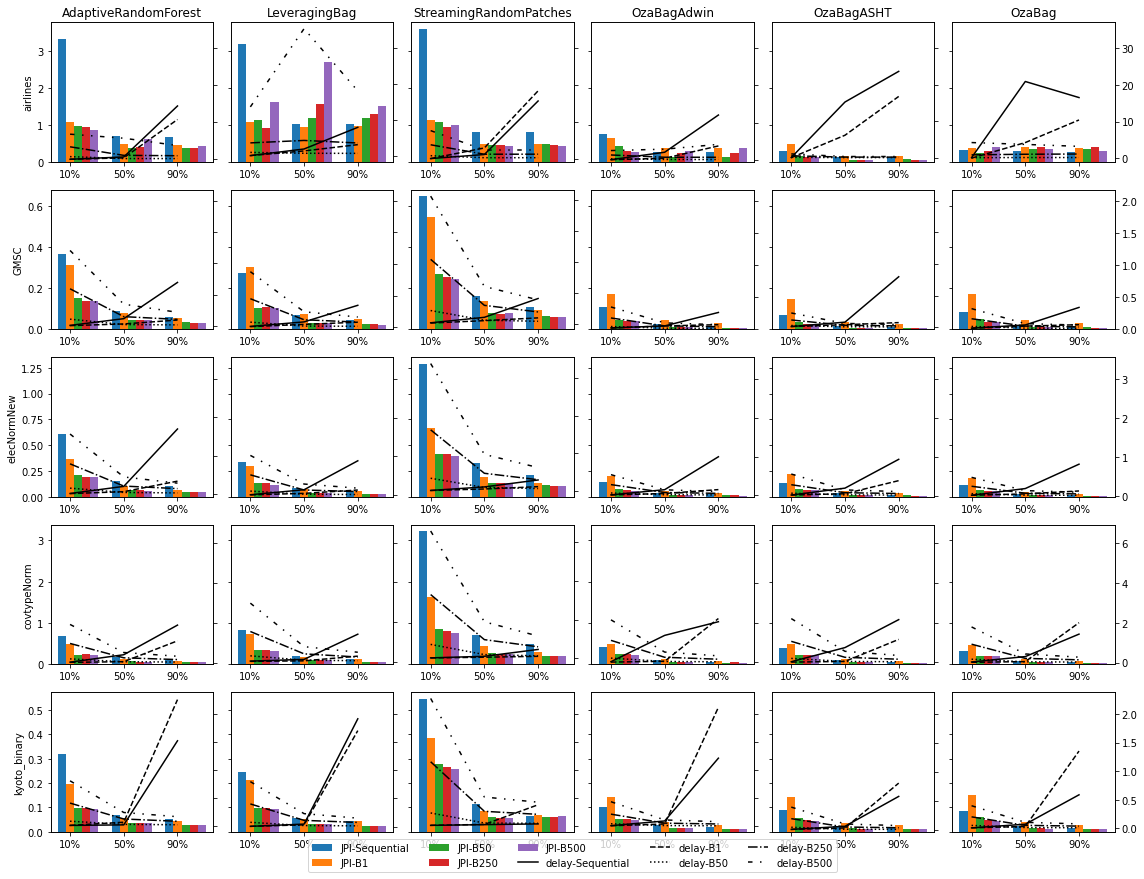

In [37]:
for arch,df in zip(architectures,dataframes):
    print(f'\n\n\n----------------- {arch} -----------------')
#     gen_graph(df, bars=True, share_y=False, arch=arch.title())
#     gen_graph(df, bars=True, share_y=False, log_y=True, arch=arch.title())
    gen_graph(df, bars=True, arch=arch.title())

In [38]:
architectures = ['vostro', 'xeon', 'pi']
dataframes = []
for a in architectures:
    dataframes.append(read_data_create_final_dataframe(a, True))

moaDF: 450    mdf: 450     sshDF: 450
moaDF: 450    mdf: 450     sshDF: 450
moaDF: 450    mdf: 450     sshDF: 450





----------------- vostro -----------------
Vostro
bars: True
share_y: row
log_y: False 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


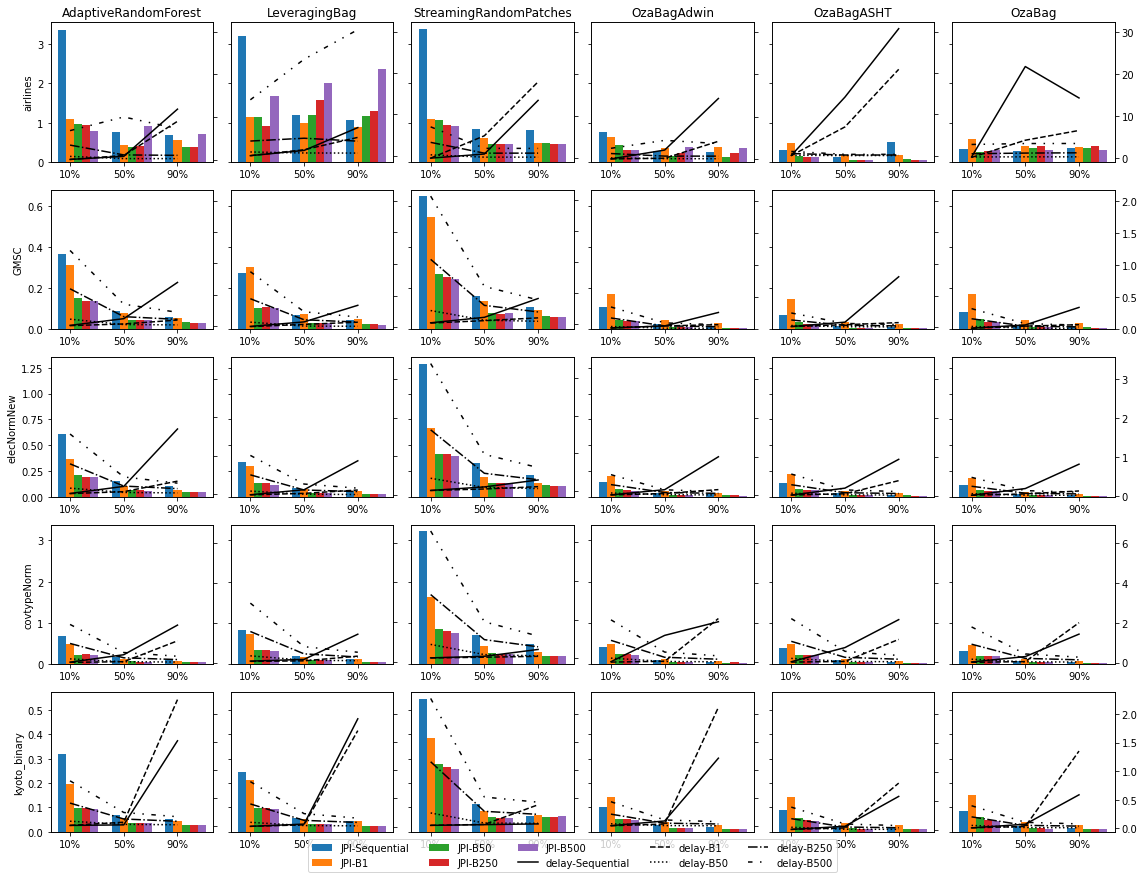




----------------- xeon -----------------
Xeon
bars: True
share_y: row
log_y: False 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


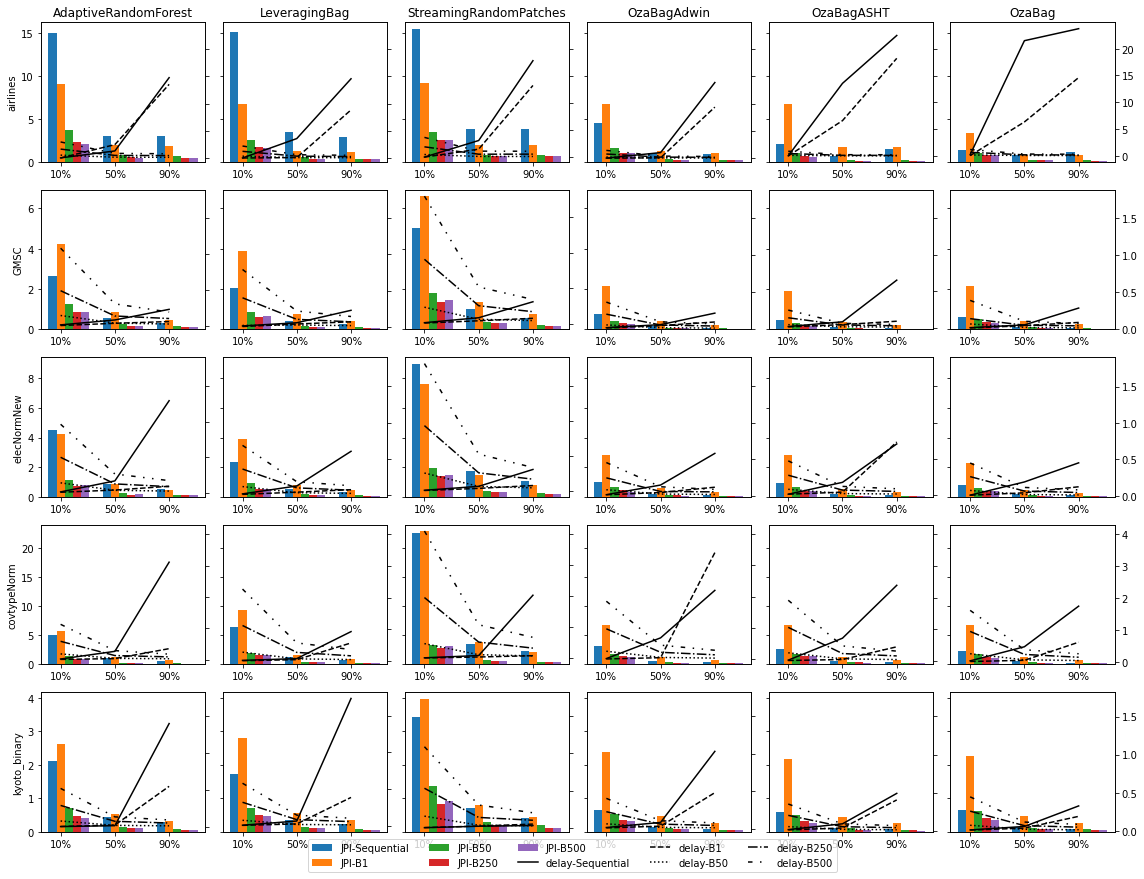




----------------- pi -----------------
Pi
bars: True
share_y: row
log_y: False 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


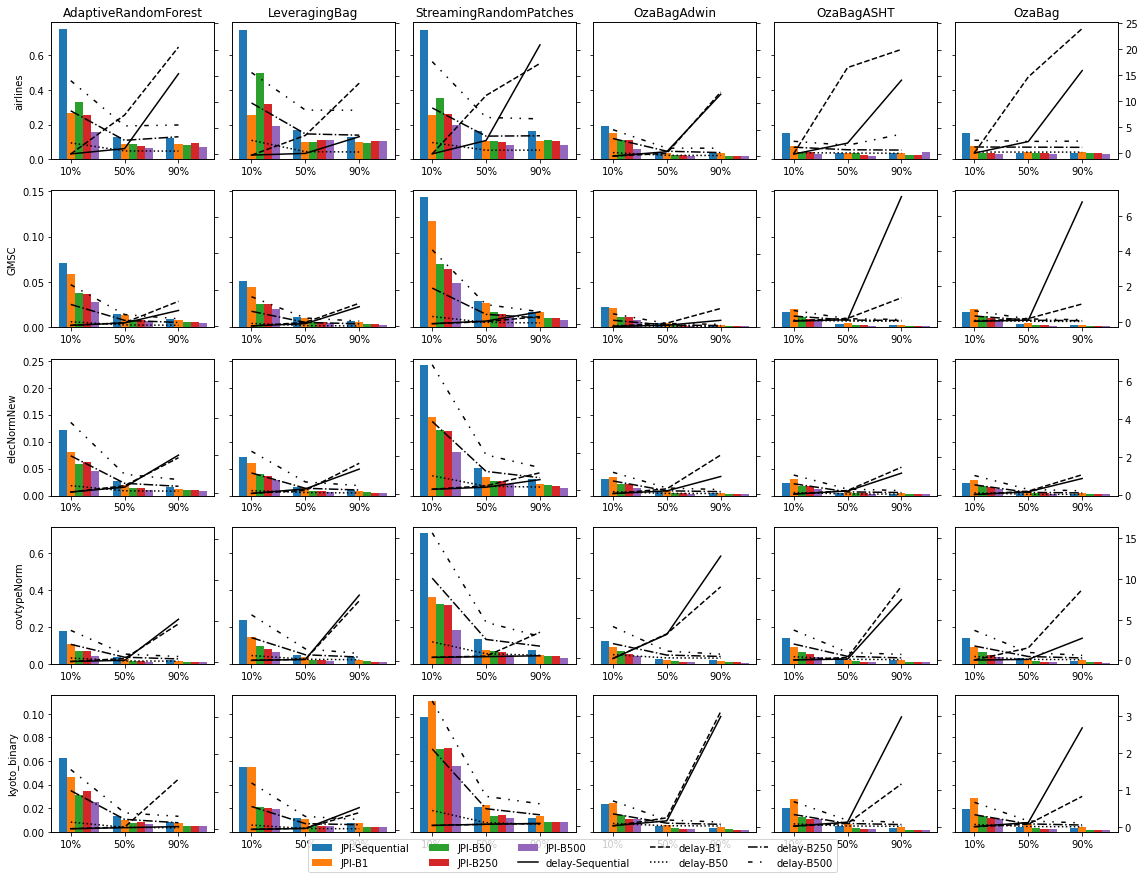

In [39]:
for arch,df in zip(architectures,dataframes):
    print(f'\n\n\n----------------- {arch} -----------------')
#     gen_graph(df, bars=True, share_y=False, arch=arch.title())
#     gen_graph(df, bars=True, share_y=False, log_y=True, arch=arch.title())
    gen_graph(df, bars=True, arch=arch.title())

In [51]:
def aux2_tput(df, ax, mTput, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    width = 0.15
    alg_order = ['Sequential', 'B1', 'B50', 'B250', 'B500']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = len(alg_order)
    for i in range(versions):
        adf = df.iloc[[i]]
        values = [adf.tput_10.iloc[0], adf.tput_50.iloc[0], adf.tput_90.iloc[0]]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values, width, label=f'Tput-{alg_order[i]}')
        else:
            lns_l += ax.plot(x, values, label=f'Tput-{alg_order[i]}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if log_y:
        ax.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if share_y == 'row':
        ax.set_ylim(bottom=0, top=mTput)

In [58]:
def aux_tput(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     get max value from delay for all rates on all algorithms for this dataset
    mLstTput = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstTput.append(rtDF.tput.max())
        mTput = max(mLstTput)*1.05
    else:
        mTput = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
        # debug print, if it shows it is wrong
        if len(showdf) != 5:
            display(showdf)   
        display(showdf[['algorithm','dataset','batch_size','cores','tput_10', 'tput_50', 'tput_90']])
        if 'Ada' in alg:
            aux2_tput(showdf, axis[id_ds][algs.index(alg)], mTput, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            aux2_tput(showdf, axis[id_ds][algs.index(alg)], mTput, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [59]:
def show_tput(df, share_y='row', bars=False, log_y=False, norm=False, arch='Vostro'):
    print(f'{arch}\nshare_y: {share_y}\nlog_y: {log_y}\nnorm: {norm}')
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm', 'kyoto_binary']
    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
#     for ds in ['airlines']:
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_tput(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = False
    lines, labels = axis[0][0].get_legend_handles_labels()
    lgd = fig.legend(lines, labels, loc=8, ncol=5, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-Tput'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'../figures/{arch}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'../figures/{arch}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()




----------------- vostro -----------------
Vostro
share_y: row
log_y: False
norm: False


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,airlines,1,1,9.99,69.87,77.58
1,AdaptiveRandomForestExecutorRUNPER,airlines,1,4,34.98,140.27,104.28
2,AdaptiveRandomForestExecutorMAXChunk,airlines,50,4,44.90,227.70,233.96
3,AdaptiveRandomForestExecutorMAXChunk,airlines,250,4,49.42,230.89,254.70
4,AdaptiveRandomForestExecutorMAXChunk,airlines,500,4,48.97,49.82,68.77


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,airlines,1,1,9.99,37.05,46.56
1,LBagExecutorRUNPER,airlines,1,4,34.96,45.68,53.46
2,LBagExecutorMAXChunk,airlines,50,4,34.92,74.44,78.12
3,LBagExecutorMAXChunk,airlines,250,4,49.19,58.95,71.05
4,LBagExecutorMAXChunk,airlines,500,4,20.01,20.80,16.21


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,airlines,1,1,9.99,66.35,67.40
1,StreamingRandomPatchesExecutorRUNPER,airlines,1,4,34.97,141.91,172.47
2,StreamingRandomPatchesExecutorMAXChunk,airlines,50,4,39.94,198.25,196.40
3,StreamingRandomPatchesExecutorMAXChunk,airlines,250,4,45.01,208.19,206.97
4,StreamingRandomPatchesExecutorMAXChunk,airlines,500,4,45.01,211.89,214.42


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,airlines,1,1,44.99,165.46,171.23
1,OzaBagAdwinExecutorRUNPER,airlines,1,4,54.92,140.41,123.29
2,OzaBagAdwinExecutorMAXChunk,airlines,50,4,99.84,518.69,722.21
3,OzaBagAdwinExecutorMAXChunk,airlines,250,4,129.98,364.53,371.74
4,OzaBagAdwinExecutorMAXChunk,airlines,500,4,144.57,113.68,137.27


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,airlines,1,1,129.76,407.08,105.57
1,OzaBagASHTExecutorRUNPER,airlines,1,4,74.87,310.27,310.57
2,OzaBagASHTExecutorMAXChunk,airlines,50,4,304.75,"1,385.49","1,012.32"
3,OzaBagASHTExecutorMAXChunk,airlines,250,4,344.76,"1,480.42","1,474.29"
4,OzaBagASHTExecutorMAXChunk,airlines,500,4,349.71,"1,501.80","1,495.56"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,airlines,1,1,129.76,163.00,120.75
1,OzaBagExecutorRUNPER,airlines,1,4,70.41,116.81,124.96
2,OzaBagExecutorMAXChunk,airlines,50,4,242.52,254.72,259.88
3,OzaBagExecutorMAXChunk,airlines,250,4,237.23,229.37,216.89
4,OzaBagExecutorMAXChunk,airlines,500,4,146.50,148.59,148.13


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,GMSC,1,1,89.85,464.06,823.47
1,AdaptiveRandomForestExecutorRUNPER,GMSC,1,4,104.82,523.99,946.47
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,50,4,224.87,"1,121.24","2,023.61"
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,250,4,244.89,"1,228.85","2,206.56"
4,AdaptiveRandomForestExecutorMAXChunk,GMSC,500,4,239.90,"1,216.76","2,191.48"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,GMSC,1,1,119.80,613.50,"1,106.09"
1,LBagExecutorRUNPER,GMSC,1,4,109.81,568.72,"1,021.18"
2,LBagExecutorMAXChunk,GMSC,50,4,324.73,"1,620.96","2,918.80"
3,LBagExecutorMAXChunk,GMSC,250,4,319.77,"1,615.91","2,901.58"
4,LBagExecutorMAXChunk,GMSC,500,4,334.76,"1,670.83","3,000.36"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,GMSC,1,1,49.96,259.70,463.83
1,StreamingRandomPatchesExecutorRUNPER,GMSC,1,4,59.93,314.55,568.48
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,129.94,663.18,"1,188.94"
3,StreamingRandomPatchesExecutorMAXChunk,GMSC,250,4,139.82,697.03,"1,249.09"
4,StreamingRandomPatchesExecutorMAXChunk,GMSC,500,4,139.98,703.99,"1,259.75"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,GMSC,1,1,294.82,"1,475.10","2,661.70"
1,OzaBagAdwinExecutorRUNPER,GMSC,1,4,189.93,962.11,"1,730.80"
2,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,778.33,"3,891.15","7,010.00"
3,OzaBagAdwinExecutorMAXChunk,GMSC,250,4,842.11,"4,231.43","7,606.69"
4,OzaBagAdwinExecutorMAXChunk,GMSC,500,4,863.43,"4,327.51","7,776.79"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,GMSC,1,1,449.54,"2,259.48","4,073.21"
1,OzaBagASHTExecutorRUNPER,GMSC,1,4,224.86,"1,126.39","2,029.80"
2,OzaBagASHTExecutorMAXChunk,GMSC,50,4,"1,012.68","5,083.71","9,110.46"
3,OzaBagASHTExecutorMAXChunk,GMSC,250,4,"1,231.29","6,167.52","11,014.78"
4,OzaBagASHTExecutorMAXChunk,GMSC,500,4,"1,284.81","6,428.11","11,504.82"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,GMSC,1,1,379.59,"1,906.75","3,419.43"
1,OzaBagExecutorRUNPER,GMSC,1,4,184.93,937.44,"1,688.83"
2,OzaBagExecutorMAXChunk,GMSC,50,4,673.97,"3,379.67","6,070.42"
3,OzaBagExecutorMAXChunk,GMSC,250,4,903.22,"4,525.57","8,131.41"
4,OzaBagExecutorMAXChunk,GMSC,500,4,928.15,"4,636.07","8,325.81"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,elecNormNew,1,1,54.93,274.61,493.79
1,AdaptiveRandomForestExecutorRUNPER,elecNormNew,1,4,94.97,483.68,872.41
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,179.90,908.27,"1,635.81"
3,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,250,4,189.53,946.23,"1,704.87"
4,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,500,4,189.94,968.35,"1,751.39"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,elecNormNew,1,1,94.85,483.67,873.18
1,LBagExecutorRUNPER,elecNormNew,1,4,109.96,564.19,"1,015.80"
2,LBagExecutorMAXChunk,elecNormNew,50,4,254.75,"1,272.20","2,295.56"
3,LBagExecutorMAXChunk,elecNormNew,250,4,274.78,"1,391.13","2,507.44"
4,LBagExecutorMAXChunk,elecNormNew,500,4,284.79,"1,448.36","2,603.84"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,elecNormNew,1,1,25.01,129.86,239.65
1,StreamingRandomPatchesExecutorRUNPER,elecNormNew,1,4,49.95,269.57,483.63
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,50,4,84.99,423.88,762.07
3,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,250,4,89.98,459.03,832.13
4,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,500,4,84.86,439.56,788.21


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,elecNormNew,1,1,214.87,"1,077.91","1,936.66"
1,OzaBagAdwinExecutorRUNPER,elecNormNew,1,4,154.93,793.60,"1,432.02"
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,439.42,"2,211.20","3,999.65"
3,OzaBagAdwinExecutorMAXChunk,elecNormNew,250,4,514.24,"2,579.82","4,616.65"
4,OzaBagAdwinExecutorMAXChunk,elecNormNew,500,4,539.10,"2,717.20","4,829.28"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,elecNormNew,1,1,234.85,"1,180.40","2,110.41"
1,OzaBagASHTExecutorRUNPER,elecNormNew,1,4,149.94,747.39,"1,347.49"
2,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,423.86,"2,141.30","3,850.44"
3,OzaBagASHTExecutorMAXChunk,elecNormNew,250,4,514.30,"2,579.23","4,640.22"
4,OzaBagASHTExecutorMAXChunk,elecNormNew,500,4,524.07,"2,623.59","4,712.14"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,elecNormNew,1,1,269.77,"1,358.35","2,442.56"
1,OzaBagExecutorRUNPER,elecNormNew,1,4,179.91,897.73,"1,621.59"
2,OzaBagExecutorMAXChunk,elecNormNew,50,4,508.73,"2,551.93","4,578.36"
3,OzaBagExecutorMAXChunk,elecNormNew,250,4,589.36,"2,956.35","5,268.96"
4,OzaBagExecutorMAXChunk,elecNormNew,500,4,608.70,"3,050.49","5,423.70"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,covtypeNorm,1,1,49.96,249.73,440.84
1,AdaptiveRandomForestExecutorRUNPER,covtypeNorm,1,4,69.89,359.41,652.88
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,50,4,154.91,772.93,"1,390.14"
3,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,250,4,159.93,807.40,"1,446.71"
4,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,500,4,159.96,812.27,"1,461.56"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,covtypeNorm,1,1,40.00,204.79,373.09
1,LBagExecutorRUNPER,covtypeNorm,1,4,44.99,234.78,423.93
2,LBagExecutorMAXChunk,covtypeNorm,50,4,104.83,533.32,961.05
3,LBagExecutorMAXChunk,covtypeNorm,250,4,104.99,529.30,956.18
4,LBagExecutorMAXChunk,covtypeNorm,500,4,104.95,544.15,974.63


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,covtypeNorm,1,1,10.00,59.90,104.03
1,StreamingRandomPatchesExecutorRUNPER,covtypeNorm,1,4,20.00,104.89,189.72
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,39.97,209.72,383.87
3,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,250,4,45.01,224.87,403.22
4,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,500,4,45.01,228.08,419.54


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,covtypeNorm,1,1,84.89,440.36,785.95
1,OzaBagAdwinExecutorRUNPER,covtypeNorm,1,4,69.89,369.40,662.79
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,144.90,723.21,"1,305.39"
3,OzaBagAdwinExecutorMAXChunk,covtypeNorm,250,4,154.95,782.94,"1,409.72"
4,OzaBagAdwinExecutorMAXChunk,covtypeNorm,500,4,159.96,798.20,"1,434.83"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,covtypeNorm,1,1,89.85,447.90,796.82
1,OzaBagASHTExecutorRUNPER,covtypeNorm,1,4,69.89,364.05,662.79
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,154.89,788.04,"1,420.17"
3,OzaBagASHTExecutorMAXChunk,covtypeNorm,250,4,154.96,778.05,"1,400.95"
4,OzaBagASHTExecutorMAXChunk,covtypeNorm,500,4,144.97,728.68,"1,316.47"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,covtypeNorm,1,1,104.96,534.20,953.96
1,OzaBagExecutorRUNPER,covtypeNorm,1,4,69.89,364.29,658.00
2,OzaBagExecutorMAXChunk,covtypeNorm,50,4,179.87,917.03,"1,651.02"
3,OzaBagExecutorMAXChunk,covtypeNorm,250,4,184.91,922.02,"1,659.84"
4,OzaBagExecutorMAXChunk,covtypeNorm,500,4,189.91,962.48,"1,737.27"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,kyoto_binary,1,1,94.83,489.33,779.58
1,AdaptiveRandomForestExecutorRUNPER,kyoto_binary,1,4,159.93,797.47,"1,279.68"
2,AdaptiveRandomForestExecutorMAXChunk,kyoto_binary,50,4,319.66,"1,605.74","2,702.69"
3,AdaptiveRandomForestExecutorMAXChunk,kyoto_binary,250,4,329.61,"1,659.92","2,926.79"
4,AdaptiveRandomForestExecutorMAXChunk,kyoto_binary,500,4,334.67,"1,669.51","2,907.19"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,kyoto_binary,1,1,124.95,613.27,"1,022.02"
1,LBagExecutorRUNPER,kyoto_binary,1,4,149.94,767.28,"1,256.70"
2,LBagExecutorMAXChunk,kyoto_binary,50,4,339.63,"1,694.47","3,043.87"
3,LBagExecutorMAXChunk,kyoto_binary,250,4,339.67,"1,694.33","3,043.14"
4,LBagExecutorMAXChunk,kyoto_binary,500,4,339.67,"1,698.49","3,039.48"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,kyoto_binary,1,1,54.92,294.69,534.13
1,StreamingRandomPatchesExecutorRUNPER,kyoto_binary,1,4,79.86,414.38,676.91
2,StreamingRandomPatchesExecutorMAXChunk,kyoto_binary,50,4,114.97,574.09,947.44
3,StreamingRandomPatchesExecutorMAXChunk,kyoto_binary,250,4,114.97,583.25,978.50
4,StreamingRandomPatchesExecutorMAXChunk,kyoto_binary,500,4,114.79,594.18,974.23


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,kyoto_binary,1,1,309.70,"1,560.79","2,803.07"
1,OzaBagAdwinExecutorRUNPER,kyoto_binary,1,4,229.83,"1,160.68","1,987.88"
2,OzaBagAdwinExecutorMAXChunk,kyoto_binary,50,4,618.68,"3,101.51","5,331.44"
3,OzaBagAdwinExecutorMAXChunk,kyoto_binary,250,4,667.67,"3,346.49","5,796.42"
4,OzaBagAdwinExecutorMAXChunk,kyoto_binary,500,4,667.66,"3,357.72","5,786.75"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,kyoto_binary,1,1,344.62,"1,719.19","3,094.12"
1,OzaBagASHTExecutorRUNPER,kyoto_binary,1,4,224.84,"1,125.32","1,966.28"
2,OzaBagASHTExecutorMAXChunk,kyoto_binary,50,4,589.05,"2,942.82","5,134.12"
3,OzaBagASHTExecutorMAXChunk,kyoto_binary,250,4,728.33,"3,651.57","6,265.88"
4,OzaBagASHTExecutorMAXChunk,kyoto_binary,500,4,732.53,"3,681.57","6,320.14"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,kyoto_binary,1,1,359.61,"1,810.41","3,253.75"
1,OzaBagExecutorRUNPER,kyoto_binary,1,4,214.87,"1,085.57","1,852.97"
2,OzaBagExecutorMAXChunk,kyoto_binary,50,4,534.28,"2,683.24","4,786.39"
3,OzaBagExecutorMAXChunk,kyoto_binary,250,4,707.60,"3,543.83","6,025.07"
4,OzaBagExecutorMAXChunk,kyoto_binary,500,4,717.58,"3,594.27","6,081.96"


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


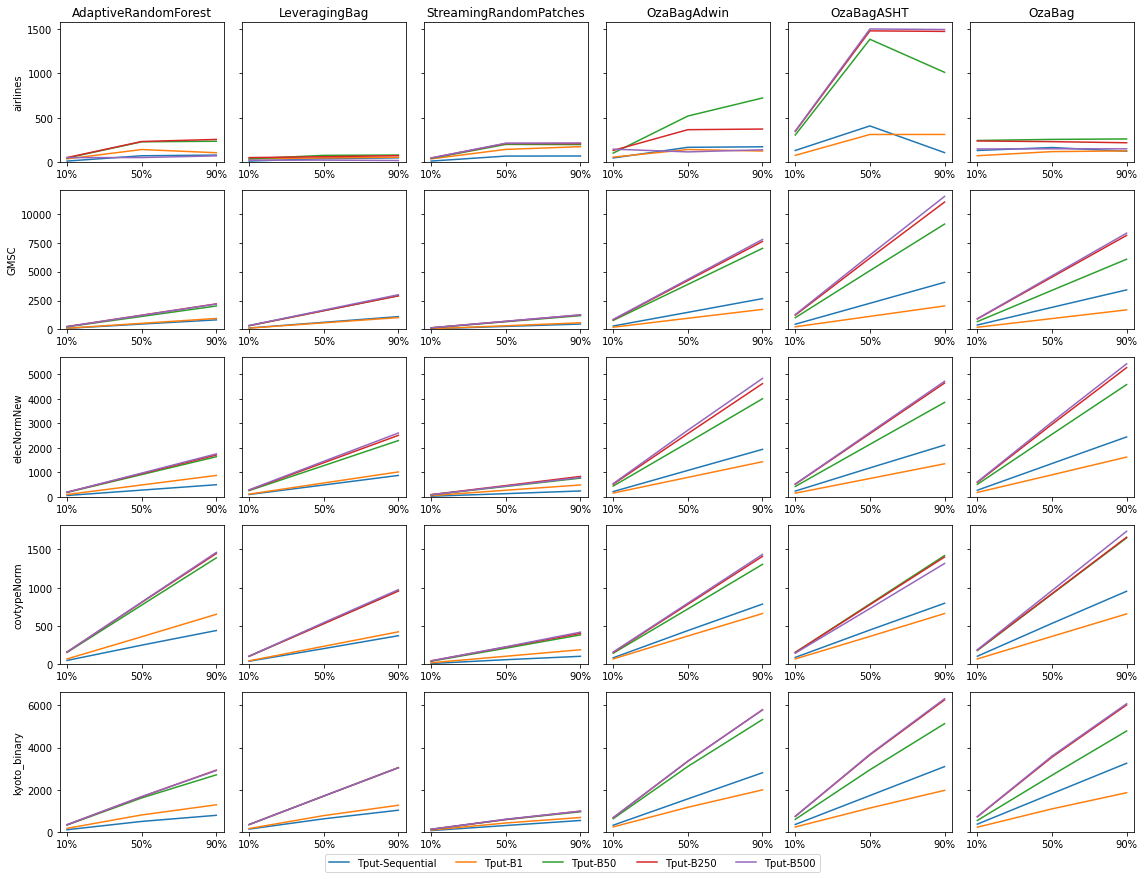




----------------- xeon -----------------
Xeon
share_y: row
log_y: False
norm: False


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,airlines,1,1,14.99,83.60,84.19
1,AdaptiveRandomForestExecutorRUNPER,airlines,1,16,24.99,123.81,134.33
2,AdaptiveRandomForestExecutorMAXChunk,airlines,50,16,59.97,309.70,386.02
3,AdaptiveRandomForestExecutorMAXChunk,airlines,250,16,99.84,506.25,556.79
4,AdaptiveRandomForestExecutorMAXChunk,airlines,500,16,114.81,579.36,638.77


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,airlines,1,1,14.99,74.06,87.82
1,LBagExecutorRUNPER,airlines,1,16,34.97,189.24,222.84
2,LBagExecutorMAXChunk,airlines,50,16,89.95,449.05,721.68
3,LBagExecutorMAXChunk,airlines,250,16,134.78,671.69,905.59
4,LBagExecutorMAXChunk,airlines,500,16,154.73,784.85,984.62


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,airlines,1,1,14.98,66.55,66.41
1,StreamingRandomPatchesExecutorRUNPER,airlines,1,16,24.99,126.92,125.91
2,StreamingRandomPatchesExecutorMAXChunk,airlines,50,16,64.95,329.12,361.09
3,StreamingRandomPatchesExecutorMAXChunk,airlines,250,16,89.51,447.11,439.98
4,StreamingRandomPatchesExecutorMAXChunk,airlines,500,16,95.00,444.08,451.94


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,airlines,1,1,49.95,254.69,289.40
1,OzaBagAdwinExecutorRUNPER,airlines,1,16,34.98,194.65,232.64
2,OzaBagAdwinExecutorMAXChunk,airlines,50,16,139.77,717.73,"1,147.99"
3,OzaBagAdwinExecutorMAXChunk,airlines,250,16,214.50,"1,089.20","1,474.36"
4,OzaBagAdwinExecutorMAXChunk,airlines,500,16,239.91,"1,193.83","1,597.99"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,airlines,1,1,114.78,366.57,174.90
1,OzaBagASHTExecutorRUNPER,airlines,1,16,34.96,141.20,141.28
2,OzaBagASHTExecutorMAXChunk,airlines,50,16,219.87,"1,100.56","1,304.00"
3,OzaBagASHTExecutorMAXChunk,airlines,250,16,359.72,"1,791.57","2,058.12"
4,OzaBagASHTExecutorMAXChunk,airlines,500,16,378.75,"1,904.49","2,058.16"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,airlines,1,1,169.68,341.53,220.31
1,OzaBagExecutorRUNPER,airlines,1,16,69.91,304.72,308.70
2,OzaBagExecutorMAXChunk,airlines,50,16,209.85,"1,053.76","1,158.23"
3,OzaBagExecutorMAXChunk,airlines,250,16,269.87,"1,364.11","1,751.62"
4,OzaBagExecutorMAXChunk,airlines,500,16,303.84,"1,532.61","1,776.07"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,GMSC,1,1,84.86,424.24,762.63
1,AdaptiveRandomForestExecutorRUNPER,GMSC,1,16,54.95,274.68,498.74
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,50,16,174.92,892.54,"1,610.12"
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,250,16,249.89,"1,249.89","2,252.66"
4,AdaptiveRandomForestExecutorMAXChunk,GMSC,500,16,269.87,"1,357.77","2,443.39"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,GMSC,1,1,109.82,548.82,986.68
1,LBagExecutorRUNPER,GMSC,1,16,59.94,319.53,578.48
2,LBagExecutorMAXChunk,GMSC,50,16,249.83,"1,260.45","2,279.01"
3,LBagExecutorMAXChunk,GMSC,250,16,359.74,"1,796.47","3,225.88"
4,LBagExecutorMAXChunk,GMSC,500,16,364.75,"1,838.80","3,301.93"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,GMSC,1,1,44.98,239.74,436.40
1,StreamingRandomPatchesExecutorRUNPER,GMSC,1,16,35.00,174.82,314.35
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,16,119.98,603.68,"1,085.53"
3,StreamingRandomPatchesExecutorMAXChunk,GMSC,250,16,159.97,796.87,"1,431.17"
4,StreamingRandomPatchesExecutorMAXChunk,GMSC,500,16,159.97,798.81,"1,435.12"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,GMSC,1,1,299.78,"1,505.19","2,706.12"
1,OzaBagAdwinExecutorRUNPER,GMSC,1,16,109.82,568.70,"1,021.39"
2,OzaBagAdwinExecutorMAXChunk,GMSC,50,16,509.40,"2,565.46","4,606.74"
3,OzaBagAdwinExecutorMAXChunk,GMSC,250,16,714.01,"3,569.64","6,407.79"
4,OzaBagAdwinExecutorMAXChunk,GMSC,500,16,803.69,"4,023.50","7,209.11"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,GMSC,1,1,484.40,"2,427.42","4,341.78"
1,OzaBagASHTExecutorRUNPER,GMSC,1,16,124.79,638.31,"1,144.39"
2,OzaBagASHTExecutorMAXChunk,GMSC,50,16,663.98,"3,320.94","5,945.30"
3,OzaBagASHTExecutorMAXChunk,GMSC,250,16,"1,032.43","5,177.06","9,258.12"
4,OzaBagASHTExecutorMAXChunk,GMSC,500,16,"1,241.88","6,214.27","11,064.47"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,GMSC,1,1,359.66,"1,801.30","3,220.27"
1,OzaBagExecutorRUNPER,GMSC,1,16,109.82,563.74,"1,010.99"
2,OzaBagExecutorMAXChunk,GMSC,50,16,409.55,"2,051.06","3,692.40"
3,OzaBagExecutorMAXChunk,GMSC,250,16,624.26,"3,119.02","5,610.83"
4,OzaBagExecutorMAXChunk,GMSC,500,16,738.93,"3,708.83","6,628.08"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,elecNormNew,1,1,49.94,269.60,483.62
1,AdaptiveRandomForestExecutorRUNPER,elecNormNew,1,16,54.93,274.59,498.60
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,16,194.90,987.71,"1,783.94"
3,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,250,16,294.80,"1,486.76","2,682.29"
4,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,500,16,304.14,"1,537.67","2,766.98"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,elecNormNew,1,1,94.84,479.40,862.90
1,LBagExecutorRUNPER,elecNormNew,1,16,59.90,304.44,548.74
2,LBagExecutorMAXChunk,elecNormNew,50,16,229.83,"1,167.26","2,104.30"
3,LBagExecutorMAXChunk,elecNormNew,250,16,399.20,"2,006.64","3,613.40"
4,LBagExecutorMAXChunk,elecNormNew,500,16,429.51,"2,147.90","3,884.77"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,elecNormNew,1,1,25.00,134.81,244.56
1,StreamingRandomPatchesExecutorRUNPER,elecNormNew,1,16,30.00,164.82,299.36
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,50,16,109.82,568.74,"1,026.53"
3,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,250,16,159.95,801.37,"1,440.99"
4,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,500,16,164.96,823.54,"1,479.24"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,elecNormNew,1,1,229.83,"1,167.17","2,059.08"
1,OzaBagAdwinExecutorRUNPER,elecNormNew,1,16,84.86,423.88,767.57
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,16,339.65,"1,709.31","3,076.80"
3,OzaBagAdwinExecutorMAXChunk,elecNormNew,250,16,498.71,"2,499.70","4,479.06"
4,OzaBagAdwinExecutorMAXChunk,elecNormNew,500,16,634.40,"3,212.25","5,716.16"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,elecNormNew,1,1,249.81,"1,258.46","2,239.95"
1,OzaBagASHTExecutorRUNPER,elecNormNew,1,16,84.86,429.31,772.57
2,OzaBagASHTExecutorMAXChunk,elecNormNew,50,16,344.67,"1,746.67","3,131.01"
3,OzaBagASHTExecutorMAXChunk,elecNormNew,250,16,534.07,"2,681.18","4,818.44"
4,OzaBagASHTExecutorMAXChunk,elecNormNew,500,16,618.81,"3,094.03","5,593.38"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,elecNormNew,1,1,289.75,"1,464.37","2,515.18"
1,OzaBagExecutorRUNPER,elecNormNew,1,16,104.83,523.84,941.39
2,OzaBagExecutorMAXChunk,elecNormNew,50,16,364.61,"1,819.83","3,270.92"
3,OzaBagExecutorMAXChunk,elecNormNew,250,16,553.67,"2,775.11","4,956.35"
4,OzaBagExecutorMAXChunk,elecNormNew,500,16,634.43,"3,212.02","5,716.16"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,covtypeNorm,1,1,44.97,224.67,408.90
1,AdaptiveRandomForestExecutorRUNPER,covtypeNorm,1,16,40.00,204.71,374.07
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,50,16,154.91,788.09,"1,412.46"
3,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,250,16,259.82,"1,311.55","2,348.61"
4,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,500,16,269.79,"1,360.86","2,432.34"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,covtypeNorm,1,1,35.00,184.83,339.46
1,LBagExecutorRUNPER,covtypeNorm,1,16,25.01,144.87,264.57
2,LBagExecutorMAXChunk,covtypeNorm,50,16,109.98,558.30,"1,001.19"
3,LBagExecutorMAXChunk,covtypeNorm,250,16,139.49,708.62,"1,274.84"
4,LBagExecutorMAXChunk,covtypeNorm,500,16,139.98,702.79,"1,262.31"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,covtypeNorm,1,1,10.00,69.88,113.59
1,StreamingRandomPatchesExecutorRUNPER,covtypeNorm,1,16,10.00,59.91,114.58
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,16,64.90,339.53,607.32
3,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,250,16,79.87,409.51,736.37
4,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,500,16,74.88,394.56,710.58


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,covtypeNorm,1,1,74.88,379.41,679.29
1,OzaBagAdwinExecutorRUNPER,covtypeNorm,1,16,35.00,184.78,329.57
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,16,119.98,618.14,"1,115.68"
3,OzaBagAdwinExecutorMAXChunk,covtypeNorm,250,16,164.55,842.20,"1,515.60"
4,OzaBagAdwinExecutorMAXChunk,covtypeNorm,500,16,174.93,877.84,"1,575.96"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,covtypeNorm,1,1,84.86,423.96,755.50
1,OzaBagASHTExecutorRUNPER,covtypeNorm,1,16,35.00,189.80,344.11
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,16,119.97,603.10,"1,090.57"
3,OzaBagASHTExecutorMAXChunk,covtypeNorm,250,16,149.95,748.64,"1,345.04"
4,OzaBagASHTExecutorMAXChunk,covtypeNorm,500,16,164.95,833.10,"1,497.09"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,covtypeNorm,1,1,99.95,508.49,904.69
1,OzaBagExecutorRUNPER,covtypeNorm,1,16,35.00,194.76,349.43
2,OzaBagExecutorMAXChunk,covtypeNorm,50,16,119.97,618.17,"1,110.52"
3,OzaBagExecutorMAXChunk,covtypeNorm,250,16,169.94,857.44,"1,549.03"
4,OzaBagExecutorMAXChunk,covtypeNorm,500,16,199.91,996.83,"1,791.10"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,kyoto_binary,1,1,104.81,528.60,827.88
1,AdaptiveRandomForestExecutorRUNPER,kyoto_binary,1,16,89.84,454.02,771.01
2,AdaptiveRandomForestExecutorMAXChunk,kyoto_binary,50,16,319.69,"1,595.35","2,807.27"
3,AdaptiveRandomForestExecutorMAXChunk,kyoto_binary,250,16,469.31,"2,366.21","4,257.52"
4,AdaptiveRandomForestExecutorMAXChunk,kyoto_binary,500,16,529.22,"2,661.72","4,767.34"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,kyoto_binary,1,1,129.96,667.78,"1,095.20"
1,LBagExecutorRUNPER,kyoto_binary,1,16,84.85,424.18,706.55
2,LBagExecutorMAXChunk,kyoto_binary,50,16,324.69,"1,620.79","2,921.86"
3,LBagExecutorMAXChunk,kyoto_binary,250,16,429.35,"2,167.25","3,889.32"
4,LBagExecutorMAXChunk,kyoto_binary,500,16,479.09,"2,412.30","4,311.10"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,kyoto_binary,1,1,64.90,324.61,583.50
1,StreamingRandomPatchesExecutorRUNPER,kyoto_binary,1,16,59.91,299.56,538.44
2,StreamingRandomPatchesExecutorMAXChunk,kyoto_binary,50,16,164.91,841.62,"1,347.89"
3,StreamingRandomPatchesExecutorMAXChunk,kyoto_binary,250,16,259.83,"1,284.91","2,183.30"
4,StreamingRandomPatchesExecutorMAXChunk,kyoto_binary,500,16,254.64,"1,280.80","2,231.23"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,kyoto_binary,1,1,339.64,"1,694.55","3,045.82"
1,OzaBagAdwinExecutorRUNPER,kyoto_binary,1,16,99.96,513.61,913.23
2,OzaBagAdwinExecutorMAXChunk,kyoto_binary,50,16,434.41,"2,187.06","3,926.38"
3,OzaBagAdwinExecutorMAXChunk,kyoto_binary,250,16,633.11,"3,169.96","5,564.40"
4,OzaBagAdwinExecutorMAXChunk,kyoto_binary,500,16,717.57,"3,611.58","6,220.45"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,kyoto_binary,1,1,394.52,"1,974.37","3,506.00"
1,OzaBagASHTExecutorRUNPER,kyoto_binary,1,16,109.80,553.39,979.43
2,OzaBagASHTExecutorMAXChunk,kyoto_binary,50,16,449.32,"2,255.34","4,054.93"
3,OzaBagASHTExecutorMAXChunk,kyoto_binary,250,16,712.58,"3,568.10","6,071.21"
4,OzaBagASHTExecutorMAXChunk,kyoto_binary,500,16,838.18,"4,189.75","7,208.19"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,kyoto_binary,1,1,349.68,"1,759.10","3,164.00"
1,OzaBagExecutorRUNPER,kyoto_binary,1,16,104.81,528.45,951.23
2,OzaBagExecutorMAXChunk,kyoto_binary,50,16,369.57,"1,863.65","3,352.97"
3,OzaBagExecutorMAXChunk,kyoto_binary,250,16,539.16,"2,697.53","4,797.44"
4,OzaBagExecutorMAXChunk,kyoto_binary,500,16,643.92,"3,234.08","5,576.80"


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


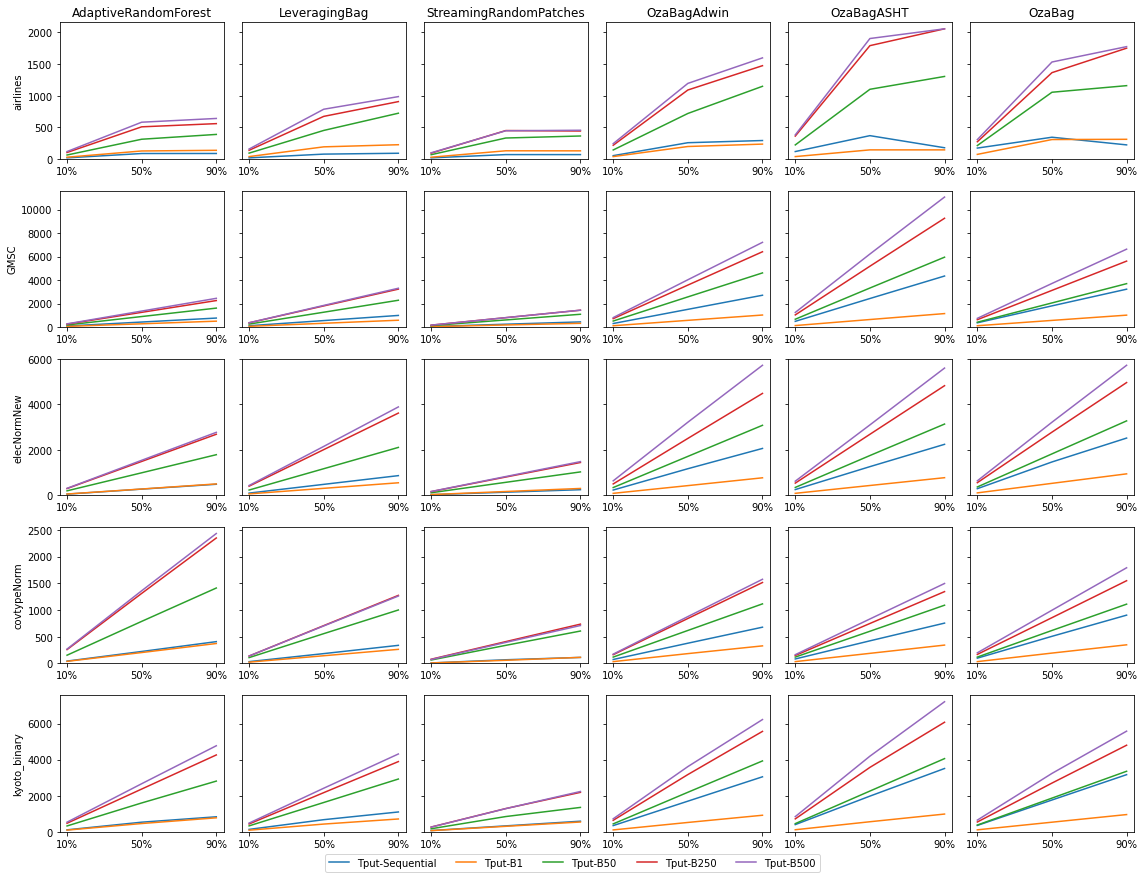




----------------- pi -----------------
Pi
share_y: row
log_y: False
norm: False


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,airlines,1,1,4.98,34.56,36.57
1,AdaptiveRandomForestExecutorRUNPER,airlines,1,4,14.99,58.35,58.15
2,AdaptiveRandomForestExecutorMAXChunk,airlines,50,4,14.97,78.57,86.12
3,AdaptiveRandomForestExecutorMAXChunk,airlines,250,4,20.01,93.23,74.74
4,AdaptiveRandomForestExecutorMAXChunk,airlines,500,4,24.43,91.10,88.91


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,airlines,1,1,4.99,24.83,34.21
1,LBagExecutorRUNPER,airlines,1,4,14.98,59.15,59.56
2,LBagExecutorMAXChunk,airlines,50,4,9.99,64.77,79.48
3,LBagExecutorMAXChunk,airlines,250,4,15.01,60.05,65.07
4,LBagExecutorMAXChunk,airlines,500,4,20.01,57.43,58.03


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,airlines,1,1,4.99,27.07,27.22
1,StreamingRandomPatchesExecutorRUNPER,airlines,1,4,14.98,49.83,50.01
2,StreamingRandomPatchesExecutorMAXChunk,airlines,50,4,14.94,67.09,65.00
3,StreamingRandomPatchesExecutorMAXChunk,airlines,250,4,20.01,71.90,70.94
4,StreamingRandomPatchesExecutorMAXChunk,airlines,500,4,20.01,70.18,73.52


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,airlines,1,1,19.99,102.85,122.47
1,OzaBagAdwinExecutorRUNPER,airlines,1,4,24.99,129.57,141.77
2,OzaBagAdwinExecutorMAXChunk,airlines,50,4,44.96,234.48,357.87
3,OzaBagAdwinExecutorMAXChunk,airlines,250,4,45.01,243.57,360.02
4,OzaBagAdwinExecutorMAXChunk,airlines,500,4,65.01,324.33,327.36


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,airlines,1,1,24.99,118.02,123.96
1,OzaBagASHTExecutorRUNPER,airlines,1,4,54.90,145.68,140.62
2,OzaBagASHTExecutorMAXChunk,airlines,50,4,134.41,188.66,250.92
3,OzaBagASHTExecutorMAXChunk,airlines,250,4,149.75,285.00,305.35
4,OzaBagASHTExecutorMAXChunk,airlines,500,4,169.71,287.25,129.31


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,airlines,1,1,24.99,114.92,125.01
1,OzaBagExecutorRUNPER,airlines,1,4,54.89,137.89,133.91
2,OzaBagExecutorMAXChunk,airlines,50,4,159.73,203.00,204.08
3,OzaBagExecutorMAXChunk,airlines,250,4,176.58,208.17,215.11
4,OzaBagExecutorMAXChunk,airlines,500,4,169.71,216.61,211.46


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,GMSC,1,1,49.95,264.66,473.74
1,AdaptiveRandomForestExecutorRUNPER,GMSC,1,4,59.94,299.62,543.75
2,AdaptiveRandomForestExecutorMAXChunk,GMSC,50,4,129.78,663.20,"1,181.84"
3,AdaptiveRandomForestExecutorMAXChunk,GMSC,250,4,129.78,667.94,"1,187.04"
4,AdaptiveRandomForestExecutorMAXChunk,GMSC,500,4,134.77,679.11,"1,215.01"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,GMSC,1,1,69.92,354.60,638.18
1,LBagExecutorRUNPER,GMSC,1,4,79.87,409.38,737.48
2,LBagExecutorMAXChunk,GMSC,50,4,184.92,927.46,"1,671.37"
3,LBagExecutorMAXChunk,GMSC,250,4,189.72,952.99,"1,709.19"
4,LBagExecutorMAXChunk,GMSC,500,4,189.97,945.55,"1,692.19"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,GMSC,1,1,25.00,139.76,249.53
1,StreamingRandomPatchesExecutorRUNPER,GMSC,1,4,30.00,149.74,269.44
2,StreamingRandomPatchesExecutorMAXChunk,GMSC,50,4,69.97,349.64,628.07
3,StreamingRandomPatchesExecutorMAXChunk,GMSC,250,4,74.81,389.70,695.39
4,StreamingRandomPatchesExecutorMAXChunk,GMSC,500,4,74.67,394.68,705.41


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,GMSC,1,1,159.95,812.40,"1,463.71"
1,OzaBagAdwinExecutorRUNPER,GMSC,1,4,164.93,822.09,"1,484.43"
2,OzaBagAdwinExecutorMAXChunk,GMSC,50,4,404.41,"2,040.98","3,623.55"
3,OzaBagAdwinExecutorMAXChunk,GMSC,250,4,424.62,"2,140.41","3,658.85"
4,OzaBagAdwinExecutorMAXChunk,GMSC,500,4,444.61,"2,228.16","3,720.51"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,GMSC,1,1,214.88,"1,090.83","1,479.36"
1,OzaBagASHTExecutorRUNPER,GMSC,1,4,179.91,897.86,"1,615.09"
2,OzaBagASHTExecutorMAXChunk,GMSC,50,4,404.41,"2,028.59","3,650.67"
3,OzaBagASHTExecutorMAXChunk,GMSC,250,4,494.22,"2,488.64","4,280.11"
4,OzaBagASHTExecutorMAXChunk,GMSC,500,4,504.51,"2,521.98","4,241.57"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,GMSC,1,1,214.87,"1,091.60","1,509.14"
1,OzaBagExecutorRUNPER,GMSC,1,4,179.92,897.35,"1,613.73"
2,OzaBagExecutorMAXChunk,GMSC,50,4,384.54,"1,921.16","3,448.88"
3,OzaBagExecutorMAXChunk,GMSC,250,4,469.39,"2,353.27","4,186.04"
4,OzaBagExecutorMAXChunk,GMSC,500,4,504.54,"2,521.39","4,267.62"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,elecNormNew,1,1,30.00,154.83,279.33
1,AdaptiveRandomForestExecutorRUNPER,elecNormNew,1,4,44.97,224.67,408.02
2,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,50,4,84.99,428.92,657.99
3,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,250,4,79.99,419.20,717.01
4,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,500,4,84.99,437.21,703.22


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,elecNormNew,1,1,49.95,254.67,454.17
1,LBagExecutorRUNPER,elecNormNew,1,4,59.93,319.31,573.79
2,LBagExecutorMAXChunk,elecNormNew,50,4,124.97,628.54,"1,025.42"
3,LBagExecutorMAXChunk,elecNormNew,250,4,139.53,697.97,"1,208.65"
4,LBagExecutorMAXChunk,elecNormNew,500,4,134.97,669.45,"1,126.97"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,elecNormNew,1,1,15.00,79.92,143.52
1,StreamingRandomPatchesExecutorRUNPER,elecNormNew,1,4,25.00,129.83,229.60
2,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,50,4,39.97,214.73,342.89
3,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,250,4,40.01,209.91,378.56
4,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,500,4,45.00,224.88,405.03


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,elecNormNew,1,1,114.96,583.44,"1,041.12"
1,OzaBagAdwinExecutorRUNPER,elecNormNew,1,4,104.82,538.92,951.78
2,OzaBagAdwinExecutorMAXChunk,elecNormNew,50,4,224.86,"1,121.03","1,811.16"
3,OzaBagAdwinExecutorMAXChunk,elecNormNew,250,4,219.90,"1,098.93","1,913.05"
4,OzaBagAdwinExecutorMAXChunk,elecNormNew,500,4,259.85,"1,295.81","2,066.62"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,elecNormNew,1,1,154.94,772.77,"1,345.71"
1,OzaBagASHTExecutorRUNPER,elecNormNew,1,4,119.97,613.58,"1,074.09"
2,OzaBagASHTExecutorMAXChunk,elecNormNew,50,4,264.79,"1,343.65","1,934.81"
3,OzaBagASHTExecutorMAXChunk,elecNormNew,250,4,264.88,"1,339.64","2,212.50"
4,OzaBagASHTExecutorMAXChunk,elecNormNew,500,4,289.79,"1,448.36","2,314.66"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,elecNormNew,1,1,154.94,772.74,"1,353.92"
1,OzaBagExecutorRUNPER,elecNormNew,1,4,119.96,613.48,"1,079.17"
2,OzaBagExecutorMAXChunk,elecNormNew,50,4,259.78,"1,291.43","1,997.41"
3,OzaBagExecutorMAXChunk,elecNormNew,250,4,284.81,"1,446.42","2,352.28"
4,OzaBagExecutorMAXChunk,elecNormNew,500,4,289.79,"1,431.35","2,302.22"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,covtypeNorm,1,1,20.00,109.91,204.66
1,AdaptiveRandomForestExecutorRUNPER,covtypeNorm,1,4,35.00,174.74,314.29
2,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,50,4,69.95,357.59,626.44
3,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,250,4,74.88,382.39,674.49
4,AdaptiveRandomForestExecutorMAXChunk,covtypeNorm,500,4,89.86,452.48,755.59


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,covtypeNorm,1,1,15.01,89.85,124.43
1,LBagExecutorRUNPER,covtypeNorm,1,4,25.00,129.87,216.10
2,LBagExecutorMAXChunk,covtypeNorm,50,4,49.92,264.16,471.49
3,LBagExecutorMAXChunk,covtypeNorm,250,4,60.00,314.75,567.77
4,LBagExecutorMAXChunk,covtypeNorm,500,4,60.00,311.35,560.74


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,covtypeNorm,1,1,5.00,29.96,54.87
1,StreamingRandomPatchesExecutorRUNPER,covtypeNorm,1,4,10.00,54.92,97.08
2,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,50,4,14.98,84.86,159.79
3,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,250,4,15.01,94.99,167.77
4,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,500,4,20.01,99.83,182.75


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,covtypeNorm,1,1,29.97,169.85,193.49
1,OzaBagAdwinExecutorRUNPER,covtypeNorm,1,4,39.97,209.63,281.56
2,OzaBagAdwinExecutorMAXChunk,covtypeNorm,50,4,69.92,369.45,607.86
3,OzaBagAdwinExecutorMAXChunk,covtypeNorm,250,4,94.85,478.54,836.93
4,OzaBagAdwinExecutorMAXChunk,covtypeNorm,500,4,94.85,474.07,839.83


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,covtypeNorm,1,1,25.00,144.80,210.07
1,OzaBagASHTExecutorRUNPER,covtypeNorm,1,4,39.97,214.68,266.15
2,OzaBagASHTExecutorMAXChunk,covtypeNorm,50,4,79.91,419.10,650.39
3,OzaBagASHTExecutorMAXChunk,covtypeNorm,250,4,94.84,489.44,866.57
4,OzaBagASHTExecutorMAXChunk,covtypeNorm,500,4,94.85,487.59,695.27


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,covtypeNorm,1,1,25.00,144.84,261.90
1,OzaBagExecutorRUNPER,covtypeNorm,1,4,39.96,214.70,261.85
2,OzaBagExecutorMAXChunk,covtypeNorm,50,4,79.87,414.12,643.70
3,OzaBagExecutorMAXChunk,covtypeNorm,250,4,99.98,508.18,863.91
4,OzaBagExecutorMAXChunk,covtypeNorm,500,4,94.99,486.48,819.74


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,AdaptiveRandomForestSequential,kyoto_binary,1,1,69.89,349.48,602.18
1,AdaptiveRandomForestExecutorRUNPER,kyoto_binary,1,4,94.84,489.04,751.56
2,AdaptiveRandomForestExecutorMAXChunk,kyoto_binary,50,4,144.92,696.66,"1,208.89"
3,AdaptiveRandomForestExecutorMAXChunk,kyoto_binary,250,4,134.96,647.33,"1,216.64"
4,AdaptiveRandomForestExecutorMAXChunk,kyoto_binary,500,4,174.94,888.03,"1,323.74"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,LeveragingBag,kyoto_binary,1,1,79.86,414.45,668.26
1,LBagExecutorRUNPER,kyoto_binary,1,4,79.86,419.33,687.38
2,LBagExecutorMAXChunk,kyoto_binary,50,4,219.86,"1,116.13","1,717.66"
3,LBagExecutorMAXChunk,kyoto_binary,250,4,234.90,"1,170.77","1,765.95"
4,LBagExecutorMAXChunk,kyoto_binary,500,4,229.88,"1,152.66","1,724.99"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,StreamingRandomPatches,kyoto_binary,1,1,44.98,224.78,409.29
1,StreamingRandomPatchesExecutorRUNPER,kyoto_binary,1,4,40.00,199.82,359.52
2,StreamingRandomPatchesExecutorMAXChunk,kyoto_binary,50,4,64.96,344.65,598.60
3,StreamingRandomPatchesExecutorMAXChunk,kyoto_binary,250,4,64.90,339.71,581.47
4,StreamingRandomPatchesExecutorMAXChunk,kyoto_binary,500,4,79.86,399.55,639.93


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagAdwin,kyoto_binary,1,1,189.88,951.82,"1,499.93"
1,OzaBagAdwinExecutorRUNPER,kyoto_binary,1,4,179.91,897.37,"1,428.34"
2,OzaBagAdwinExecutorMAXChunk,kyoto_binary,50,4,334.64,"1,684.43","3,020.14"
3,OzaBagAdwinExecutorMAXChunk,kyoto_binary,250,4,429.10,"2,167.90","3,858.54"
4,OzaBagAdwinExecutorMAXChunk,kyoto_binary,500,4,439.48,"2,196.46","3,914.87"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBagASHT,kyoto_binary,1,1,219.84,"1,100.49","1,739.06"
1,OzaBagASHTExecutorRUNPER,kyoto_binary,1,4,159.93,812.53,"1,373.29"
2,OzaBagASHTExecutorMAXChunk,kyoto_binary,50,4,364.61,"1,829.74","3,282.00"
3,OzaBagASHTExecutorMAXChunk,kyoto_binary,250,4,434.47,"2,171.90","3,898.28"
4,OzaBagASHTExecutorMAXChunk,kyoto_binary,500,4,434.49,"2,186.35","3,911.69"


,algorithm,dataset,batch_size,cores,tput_10,tput_50,tput_90
0,OzaBag,kyoto_binary,1,1,229.84,"1,160.72","1,895.27"
1,OzaBagExecutorRUNPER,kyoto_binary,1,4,154.93,777.32,"1,331.80"
2,OzaBagExecutorMAXChunk,kyoto_binary,50,4,359.64,"1,814.69","3,252.73"
3,OzaBagExecutorMAXChunk,kyoto_binary,250,4,419.45,"2,102.65","3,765.50"
4,OzaBagExecutorMAXChunk,kyoto_binary,500,4,444.48,"2,221.68","3,974.65"


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


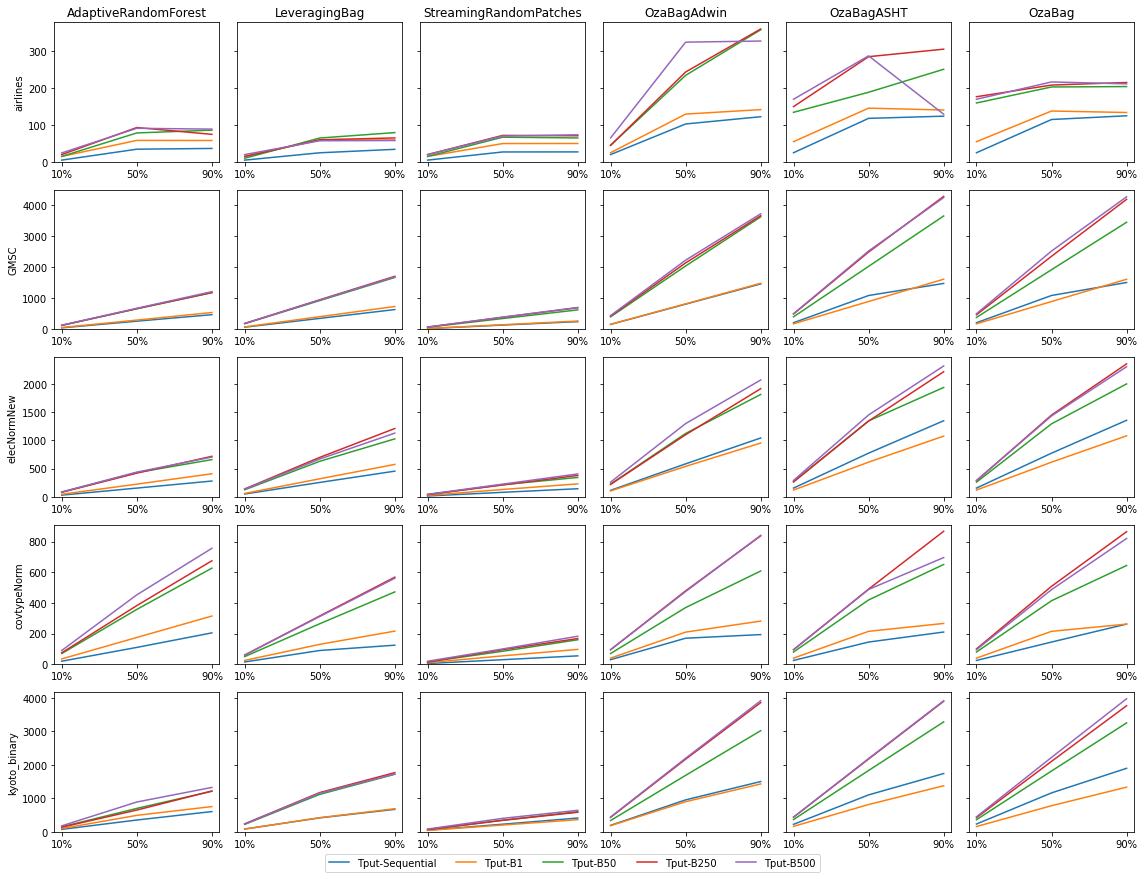

In [60]:
for arch,df in zip(architectures,dataframes):
    print(f'\n\n\n----------------- {arch} -----------------')
    show_tput(df, arch=arch.title())

d = {}
header_printed = False
moaDF = read_MOA(f"{PATH_TO_RESULTS}/Energy/vostro/socket", f"{PATH_TO_RESULTS}/Energy/vostro/inst-and-delay.csv")
moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay"]]
measureDF = load_Wmeas(f'{PATH_TO_RESULTS}/Energy/vostro/Wm-vostro.log')
d = exper_order_to_dict(f'{PATH_TO_RESULTS}/Energy/vostro/exper_order-vostro.log', d)
d = populate_dict(d, measureDF)
mdf = append_dict_to_df(d)
sshDF = parse_SSH(f'{PATH_TO_RESULTS}/Energy/vostro/ssh-log-vostro')
sshDF['batch_size'] = sshDF['batch_size'].astype(int)

#join dfs
finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
finaldf['JPI'] = finaldf['joules'] / finaldf['instances']

### Add PERC column to identify if it used 90, 50 or 10% max rate

- Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
- We use the **PERC**entage column for that

tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)
tdf['PERC'] = 0
masks = {'90':[], '50': [], '10': []}
for k, v in zip(masks.keys(), [0, 1, 2]):
    for i in range(len(tdf)):
        masks[k].append(i % 3 == v)
tdf.loc[masks['90'],'PERC'] = '90'
tdf.loc[masks['50'],'PERC'] = '50'
tdf.loc[masks['10'],'PERC'] = '10'

Sharey = row

Linear scale

gen_graph(bars=True)

sharey = False

linear scale

gen_graph(bars=True, share_y=False)

sharey = false

log scale y

gen_graph(bars=True, share_y=False, log_y=True)

gen_graph(bars=True)

def table_delta_rates_vert(ratio=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
    all_values = []
    # filtra algoritmo
    for alg in algs:
        line = '\hline\n\\multirow{3}{*}{' + alg + '} '
        algdf = filter_by_substring_algorithm(tdf, alg).sort_values(['algorithm','batch_size','cores'])
#         display(algdf)
        # filtra rate
        for rt in rates:
            if rt != '10':
                line += '\\\\\n'
            line += f' & {rt} '
            rtalgdf = rename_columns_by_rate(algdf[algdf.PERC == rt])
            # filtra dataset
            for ds in datasets:
#                 print(ds)
                dsrtalgdf = rtalgdf[rtalgdf.dataset == ds]
#                 display(dsrtalgdf)
                minoutro = min(dsrtalgdf[dsrtalgdf.batch_size == 1][f'JPI_{rt}'])
#                 print(f"JPI_{rt} minoutro {minoutro}")
                val = ((dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro)/minoutro)*100 if ratio else dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro 
                all_values.append(val)
                sval = f"{val:.2f} " if val < 0 else "\\textbf{ " + f"{val:.2f}" + "} "
                line += f"& {sval} "
        print(f"{line} \\\\")
    print(f'\n\nAverage reduction: {sum(all_values)/len(all_values)}')

table_delta_rates_vert()